**LeNet-300-100 Training**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

In [ ]:
# GPU device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Available device: {device}")

Available device: cuda


In [ ]:
# Hyper-parameters-
input_size = 784    # 28 x 28, flattened to be 1-D tensor
hidden_size = 100
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.0012

In [ ]:
# MNIST dataset statistics:
# mean = tensor([0.1307]) & std dev = tensor([0.3081])
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])

In [ ]:
# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = './data', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = './data', train = False,
        transform = transforms_apply
        )

print(f"len(train_dataset): {len(train_dataset)} & len(test_dataset): {len(test_dataset)}")

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
len(train_dataset): 60000 & len(test_dataset): 10000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 1875 & len(test_loader) = 313


In [ ]:
X, y = next(iter(train_loader))
X.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
# Reshape input so that it can be fed into LeNet-300-100 architecture model-
X.reshape(-1, input_size).shape

torch.Size([32, 784])

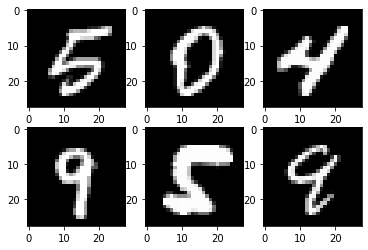

In [ ]:
# Print 6 images from training set-
for i in range(6):
    plt.subplot(2, 3, i + 1)    # 2 rows & 3 columns
    plt.imshow(X[i][0], cmap = 'gray')     # '0' to access first channel
plt.show()

In [ ]:
input_size

784

In [ ]:
class LeNet300(nn.Module):
    def __init__(self):
        super(LeNet300, self).__init__()
        
        # Define layers-
        self.fc1 = nn.Linear(in_features = input_size, out_features = 300)
        self.fc2 = nn.Linear(in_features = 300, out_features = 100)
        self.output = nn.Linear(in_features = 100, out_features = 10)
        
        self.weights_initialization()
    
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        return self.output(out)
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [ ]:
# Initialize an instance of LeNet-300-100 dense neural network-
model = LeNet300().to(device)

In [ ]:
# Sanity check-
y_pred = model(X.reshape(-1, input_size).to(device))
y_pred.shape

torch.Size([32, 10])

In [ ]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"\nLeNet-300-100 has {tot_params} parameters\n")

layer.shape = torch.Size([300, 784]) has 235200 parameters
layer.shape = torch.Size([300]) has 300 parameters
layer.shape = torch.Size([100, 300]) has 30000 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([10, 100]) has 1000 parameters
layer.shape = torch.Size([10]) has 10 parameters

LeNet-300-100 has 266610 parameters



In [ ]:
print(f"\nLeNet-300-100 model's layer names are:")
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")


LeNet-300-100 model's layer names are:
fc1.weight has dimension = torch.Size([300, 784])
fc1.bias has dimension = torch.Size([300])
fc2.weight has dimension = torch.Size([100, 300])
fc2.bias has dimension = torch.Size([100])
output.weight has dimension = torch.Size([10, 100])
output.bias has dimension = torch.Size([10])


In [ ]:
# Define loss and optimizer-
loss = nn.CrossEntropyLoss()    # applies softmax for us
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
# Training loop-
num_steps = len(train_loader)

print(f"num_steps = {num_steps} & (sanity check): len(train_dataset)/batch_size = {len(train_dataset) / batch_size}")

num_steps = 1875 & (sanity check): len(train_dataset)/batch_size = 1875.0


In [ ]:
print(f"number of training steps in one epoch = {num_steps}")

number of training steps in one epoch = 1875


In [ ]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [ ]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [ ]:
# Python3 lists to store model training metrics-
training_acc = []
validation_acc = []
training_loss = []
validation_loss = []

**Train model using Early Stopping**

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    running_loss_val = 0.0
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    
    
    for batch, (images, labels) in enumerate(train_loader):
        # Attempt to push to GPU if available-
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)

        # Set model to training mode-
        model.train()

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        J.backward()    # does backprop

        # Updates parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_training_steps}, loss = {J.item():.4f}")
        '''

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    # print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%\n")

    total = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)
            # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)
    print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")

    # Code for manual Early Stopping:
    if np.abs(epoch_val_loss < best_val_loss) >= minimum_delta:
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = epoch_val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement


    training_acc.append(epoch_acc * 100)
    validation_acc.append(val_acc)
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)



epoch: 1 training loss = 0.2023, training accuracy = 93.75%, val_loss = 0.1180 & val_accuracy = 96.35%


epoch: 2 training loss = 0.0963, training accuracy = 97.09%, val_loss = 0.1182 & val_accuracy = 96.48%


epoch: 3 training loss = 0.0723, training accuracy = 97.74%, val_loss = 0.0920 & val_accuracy = 97.25%


epoch: 4 training loss = 0.0590, training accuracy = 98.20%, val_loss = 0.1131 & val_accuracy = 96.55%


epoch: 5 training loss = 0.0496, training accuracy = 98.47%, val_loss = 0.1084 & val_accuracy = 97.20%


epoch: 6 training loss = 0.0436, training accuracy = 98.59%, val_loss = 0.0892 & val_accuracy = 97.57%


epoch: 7 training loss = 0.0370, training accuracy = 98.79%, val_loss = 0.0987 & val_accuracy = 97.63%


epoch: 8 training loss = 0.0349, training accuracy = 98.92%, val_loss = 0.0968 & val_accuracy = 97.64%


epoch: 9 training loss = 0.0323, training accuracy = 98.98%, val_loss = 0.0986 & val_accuracy = 97.89%


'EarlyStopping' called!



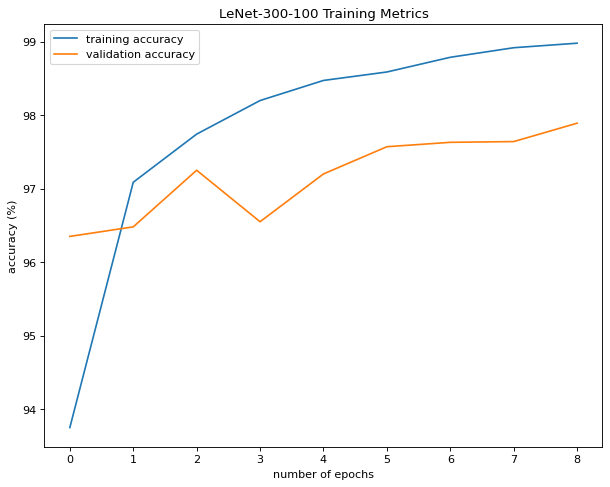

In [ ]:
# Visualize training metrics-
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(np.asarray(training_acc), label = 'training accuracy')
plt.plot(np.asarray(validation_acc), label = 'validation accuracy')

plt.title("LeNet-300-100 Training Metrics")
plt.xlabel("number of epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()


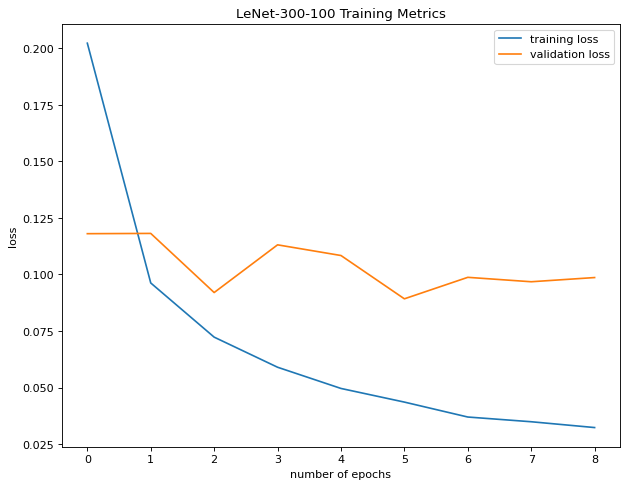

In [ ]:
# Visualize training metrics-
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(np.asarray(training_loss), label = 'training loss')
plt.plot(np.asarray(validation_loss), label = 'validation loss')

plt.title("LeNet-300-100 Training Metrics")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()


In [ ]:
def train_model(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0

    for batch, (images, labels) in enumerate(train_loader):
        # Reshape image and place it on GPU-
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device) 
        outputs = model(images)   # forward pass
        J = loss(outputs, labels) # compute loss
        optimizer.zero_grad()     # empty accumulated gradients
        J.backward()              # perform backpropagation
        optimizer.step()          # update parameters

        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_steps}, loss = {J.item():.4f}")
        '''

    return running_loss, running_corrects



In [ ]:
def test_model(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)
            # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    return (running_loss_val, correct, total)


In [ ]:
new_model = LeNet300().to(device)

In [ ]:
# Define loss and optimizer-
loss = nn.CrossEntropyLoss()    # applies softmax for us
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0

    running_loss, running_corrects = train_model(new_model, train_loader)
  
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    # epoch_acc = 100 * running_corrects / len(trainset)
    # print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%\n")

    running_loss_val, correct, total = test_model(model, test_loader)

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)
    # print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")

    print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")




epoch: 1 training loss = 2.8310, training accuracy = 9.10%, val_loss = 0.0986 & val_accuracy = 97.89%


epoch: 2 training loss = 2.8310, training accuracy = 9.10%, val_loss = 0.0986 & val_accuracy = 97.89%


epoch: 3 training loss = 2.8310, training accuracy = 9.10%, val_loss = 0.0986 & val_accuracy = 97.89%


epoch: 4 training loss = 2.8310, training accuracy = 9.10%, val_loss = 0.0986 & val_accuracy = 97.89%



KeyboardInterrupt: ignored

In [ ]:
# Training loop-
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    
    for batch, (images, labels) in enumerate(train_loader):
        # Reshape images first-
        # 32, 1, 28, 28
        # Input size needs to be 32, 784
        images = images.reshape(-1, 28 * 28 * 1).to(device)
        # Tries to push to GPU if available
        
        labels = labels.to(device)

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        J.backward()    # does backprop

        # Updates parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_steps}, loss = {J.item():.4f}")
        '''
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    # epoch_acc = 100 * running_corrects / len(trainset)
    print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%\n")


epoch 1/10, step 100/1875, loss = 0.1445
epoch 1/10, step 200/1875, loss = 0.2513
epoch 1/10, step 300/1875, loss = 0.1319
epoch 1/10, step 400/1875, loss = 0.2112
epoch 1/10, step 500/1875, loss = 0.1163
epoch 1/10, step 600/1875, loss = 0.2038
epoch 1/10, step 700/1875, loss = 0.1331
epoch 1/10, step 800/1875, loss = 0.2032
epoch 1/10, step 900/1875, loss = 0.0416
epoch 1/10, step 1000/1875, loss = 0.1949
epoch 1/10, step 1100/1875, loss = 0.0992
epoch 1/10, step 1200/1875, loss = 0.3378
epoch 1/10, step 1300/1875, loss = 0.2760
epoch 1/10, step 1400/1875, loss = 0.0504
epoch 1/10, step 1500/1875, loss = 0.2095
epoch 1/10, step 1600/1875, loss = 0.0967
epoch 1/10, step 1700/1875, loss = 0.1612
epoch 1/10, step 1800/1875, loss = 0.1670

epoch: 1 training loss = 0.2007, training accuracy = 93.98%

epoch 2/10, step 100/1875, loss = 0.0938
epoch 2/10, step 200/1875, loss = 0.0225
epoch 2/10, step 300/1875, loss = 0.1387
epoch 2/10, step 400/1875, loss = 0.0397
epoch 2/10, step 500/1875, 

In [ ]:
# Training loop-
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    
    for batch, (images, labels) in enumerate(train_loader):
        # Reshape images first-
        # 32, 1, 28, 28
        # Input size needs to be 32, 784
        images = images.reshape(-1, 28 * 28 * 1).to(device)
        # Tries to push to GPU if available
        
        labels = labels.to(device)

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        J.backward()    # does backprop

        # Updates parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_steps}, loss = {J.item():.4f}")
        '''
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    # epoch_acc = 100 * running_corrects / len(trainset)
    print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%\n")


epoch 1/10, step 100/1875, loss = 0.1445
epoch 1/10, step 200/1875, loss = 0.2513
epoch 1/10, step 300/1875, loss = 0.1319
epoch 1/10, step 400/1875, loss = 0.2112
epoch 1/10, step 500/1875, loss = 0.1163
epoch 1/10, step 600/1875, loss = 0.2038
epoch 1/10, step 700/1875, loss = 0.1331
epoch 1/10, step 800/1875, loss = 0.2032
epoch 1/10, step 900/1875, loss = 0.0416
epoch 1/10, step 1000/1875, loss = 0.1949
epoch 1/10, step 1100/1875, loss = 0.0992
epoch 1/10, step 1200/1875, loss = 0.3378
epoch 1/10, step 1300/1875, loss = 0.2760
epoch 1/10, step 1400/1875, loss = 0.0504
epoch 1/10, step 1500/1875, loss = 0.2095
epoch 1/10, step 1600/1875, loss = 0.0967
epoch 1/10, step 1700/1875, loss = 0.1612
epoch 1/10, step 1800/1875, loss = 0.1670

epoch: 1 training loss = 0.2007, training accuracy = 93.98%

epoch 2/10, step 100/1875, loss = 0.0938
epoch 2/10, step 200/1875, loss = 0.0225
epoch 2/10, step 300/1875, loss = 0.1387
epoch 2/10, step 400/1875, loss = 0.0397
epoch 2/10, step 500/1875, 

In [ ]:
# Trained model evaluation. For this, we do not want to compute gradients for
# all of the steps. Hence wrap it-
with torch.no_grad():
    num_correct = 0
    num_samples = 0

    for images, labels in test_loader:
        # Reshape images-
        images = images.reshape(-1, 28 * 28 * 1).to(device)
        labels = labels.to(device)

        outputs = model(images)

        # torch.max() returns value and index. We are interested in index
        # hence we use '_' since we don't need first value-
        _, y_pred = torch.max(outputs, 1)   # along first dimension

        # number of samples in correct batch-
        num_samples += labels.shape[0]

        num_correct += (y_pred == labels).sum().item()

    acc = 100.0 * num_correct / num_samples
    print(f"Trained model's validation accuracy = {acc:.2f}%")
    # Trained model's accuracy = 98.05%


Trained model's validation accuracy = 97.68%
